In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Function Fitting using Quantum Signal Processing
================================================

::: {.meta}
:property=\"og:description\": Learn how to create polynomial
approximations to functions using Quantum Signal Processing (QSP).
:property=\"og:image\":
<https://pennylane.ai/qml/demonstrations/function_fitting_qsp/cover.png>
:::

*Author: Jay Soni --- Posted: 24 May 2022. Last updated: 17 April 2023.*

Introduction
------------

This demo is inspired by the paper ['A Grand Unification of Quantum
Algorithms'](https://arxiv.org/abs/2105.02859). This paper is centered
around the Quantum Singular Value Transform (QSVT) protocol and how it
provides a single framework to generalize some of the most famous
quantum algorithms like Shor's factoring algorithm, Grover search, and
more.

The QSVT is a method to apply polynomial transformations to the singular
values of *any matrix*. This is powerful because from polynomial
transformations we can generate arbitrary function transformations using
Taylor approximations. The QSVT protocol is an extension of the more
constrained Quantum Signal Processing (QSP) protocol which presents a
method for polynomial transformation of matrix entries in a single-qubit
unitary operator. The QSVT protocol is sophisticated, but the idea at
its core is quite simple. By studying QSP, we get a relatively simpler
path to explore this idea at the foundation of QSVT.

In this demo, we explore the QSP protocol and how it can be used for
curve fitting. We show how you can fit polynomials, as illustrated in
the animation below.

![](../demonstrations/function_fitting_qsp/trained_poly.gif){.align-center
width="50.0%"}

This is a powerful tool that will ultimately allow us to approximate any
function on the interval $[-1, 1]$ that satisfies certain constraints.
Before we can dive into function fitting, let's develop some intuition.
Consider the following single-qubit operator parameterized by
$a \in [-1, 1]$:

$$\begin{aligned}
\hat{W}(a) = \begin{bmatrix} a & i\sqrt{1 - a^{2}} \\ i\sqrt{1 - a^{2}} & a \end{bmatrix}.
\end{aligned}$$

$\hat{W}(a)$ is called the *signal rotation operator* (SRO). Using this
operator, we can construct another operator which we call *signal
processing operator* (SPO),

$$\hat{U}_{sp} = \hat{R}_{z}(\phi_{0}) \prod_{k=1}^{d} \hat{W}(a) \hat{R}_{z}(\phi_{k}).$$

The SPO is parameterized by a vector $\vec{\phi} \in \mathbb{R}^{d+1}$,
where $d$ is a free parameter which represents the number of repeated
applications of $\hat{W}(a)$.

The SPO $\hat{U}_{sp}$ alternates between applying the SRO $\hat{W}(a)$
and parameterized rotations around the z-axis. Let's see what happens
when we try to compute the expectation value
$\langle 0|\hat{U}_{sp}|0\rangle$ for the particular case where $d = 2$
and $\vec{\phi} = (0, 0, 0)$ :

$$\begin{aligned}
\begin{align*}
\langle 0 |\hat{U}_{sp}|0\rangle &= \langle 0 | \ \hat{R}_{z}(0) \prod_{k=1}^{2} \hat{W}(a) \hat{R}_{z}(0) \ |0\rangle \\
\langle 0 |\hat{U}_{sp}|0\rangle &= \langle 0 | \hat{W}(a)^{2} |0\rangle \\
\end{align*}
\end{aligned}$$

$$\begin{aligned}
\langle 0 |\hat{U}_{sp}|0\rangle = \langle 0 | \begin{bmatrix} a & i\sqrt{1 - a^{2}} \\ i\sqrt{1 - a^{2}} & a \end{bmatrix} \ \circ \ \begin{bmatrix} a & i\sqrt{1 - a^{2}} \\ i\sqrt{1 - a^{2}} & a \end{bmatrix} |0\rangle
\end{aligned}$$

$$\begin{aligned}
\langle 0|\hat{U}_{sp}|0\rangle = \langle 0| \begin{bmatrix} 2a^{2} - 1 & 2ai\sqrt{1 - a^{2}} \\ 2ai\sqrt{1 - a^{2}} & 2a^{2} - 1 \end{bmatrix} |0\rangle
\end{aligned}$$

$$\langle 0|\hat{U}_{sp}|0\rangle = 2a^{2} - 1$$

Notice that this quantity is a polynomial in $a$. Equivalently, suppose
we wanted to create a map $S: a \to 2a^2 - 1$. This expectation value
would give us the means to perform such a mapping. This may seem oddly
specific at first, but it turns out that this process can be generalized
for generating a mapping $S: a \to \text{poly}(a)$. The following
theorem shows us how:

### Theorem: Quantum Signal Processing

Given a vector $\vec{\phi} \in \mathbb{R}^{d+1}$, there exist complex
polynomials $P(a)$ and $Q(a)$ such that the SPO, $\hat{U}_{sp}$, can be
expressed in matrix form as:

$$\hat{U}_{sp} = \hat{R}_{z}(\phi_{0}) \prod_{k=1}^{d} \hat{W}(a) \hat{R}_{z}(\phi_{k}),$$

$$\begin{aligned}
\hat{U}_{sp} = \begin{bmatrix} P(a) & iQ(a)\sqrt{1 - a^{2}} \\ iQ^{*}(a)\sqrt{1 - a^{2}} & P^{*}(a) \end{bmatrix},
\end{aligned}$$

where $a \in [-1, 1]$ and the polynomials $P(a)$, $Q(a)$ satisfy the
following constraints:

-   $deg(P) \leq d \ $ and $deg(Q) \leq d - 1$,
-   $P$ has parity $d$ mod 2 and $Q$ has parity, $d - 1$ mod 2
-   $|P|^{2} + (1 - a^{2})|Q|^{2} = 1$.

The third condition is actually quite restrictive because if we
substitute $a = \pm 1$, we get the result $|P^{2}(\pm 1)| = 1$. Thus it
restricts the polynomial to be pinned to $\pm 1$ at the end points of
the domain, $a = \pm 1$. This condition can be relaxed to
$|P^{2}(a)| \leq 1$ by expressing the signal processing operator in the
Hadamard basis, i.e., $\langle + |\hat{U}_{sp}(\vec{\phi};a)|+\rangle$).
This is equivalent to redefining $P(a)$ such that:

$$P^{'}(a) = \text{Re}(P(a)) + i\text{Re}(Q(a))\sqrt{1 - a^{2}}$$

*This is the convention we follow in this demo.*


Let\'s Plot some Polynomials
============================

Now we put this theorem to the test! In this section we construct the
SRO $\hat{W}(a)$, and then use PennyLane to define the SPO. To test the
theorem we will randomly generate parameters $\vec{\phi}$ and plot the
expectation value $\langle + |\hat{U}_{sp}(\vec{\phi};a)|+\rangle$ for
$a \in [-1, 1]$.


Next, we introduce a function called `rotation_mat(a)`, which will
construct the SRO matrix. We can also make a helper function
(`generate_many_sro(a_vals)`) which, given an array of possible values
for '$a$', will generate an array of $\hat{W}(a)$ associated with each
element. We use Pytorch to construct this array as it will later be used
as input when training our function fitting model.


In [2]:
import torch


def rotation_mat(a):
    """Given a fixed value 'a', compute the signal rotation matrix W(a).
    (requires -1 <= 'a' <= 1)
    """
    diag = a
    off_diag = (1 - a**2) ** (1 / 2) * 1j
    W = [[diag, off_diag], [off_diag, diag]]

    return W


def generate_many_sro(a_vals):
    """Given a tensor of possible 'a' vals, return a tensor of W(a)"""
    w_array = []
    for a in a_vals:
        w = rotation_mat(a)
        w_array.append(w)

    return torch.tensor(w_array, dtype=torch.complex64, requires_grad=False)

Now having access to the matrix elements of the SRO, we can leverage
PennyLane to define a quantum function that will compute the SPO. Recall
we are measuring in the Hadamard basis to relax the third condition of
the theorem. We accomplish this by sandwiching the SPO between two
Hadamard gates to account for this change of basis.


In [3]:
import pennylane as qml


def QSP_circ(phi, W):
    """This circuit applies the SPO. The components in the matrix
    representation of the final unitary are polynomials!
    """
    qml.Hadamard(wires=0)  # set initial state |+>
    for angle in phi[:-1]:
        qml.RZ(angle, wires=0)
        qml.QubitUnitary(W, wires=0)

    qml.RZ(phi[-1], wires=0)  # final rotation
    qml.Hadamard(wires=0)  # change of basis |+> , |->
    return

Finally, we randomly generate the vector $\vec{\phi}$ and plot the
expectation value $\langle +|\hat{U}_{sp}|+\rangle$ as a function of
$a$. In this case we choose $d = 5$. We expect to observe the following:

-   Since $d$ is odd, we expect all of the polynomials we plot to have
    odd symmetry
-   Since $d = 5$, we expect none of the polynomials will have terms \~
    $O(a^6)$ or higher
-   All of the polynomials are bounded by $\pm1$


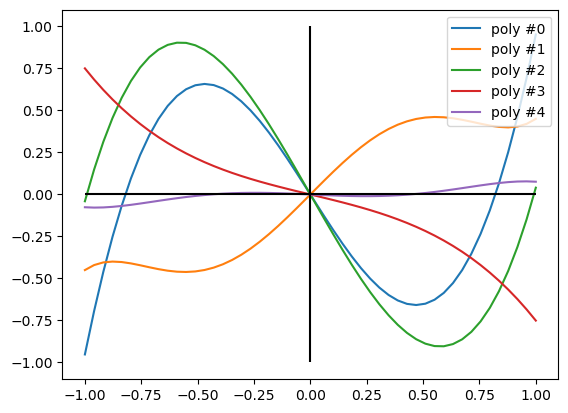

In [4]:
import math
import matplotlib.pyplot as plt

d = 5
a_vals = torch.linspace(-1, 1, 50)
w_mats = generate_many_sro(a_vals)

gen = torch.Generator()
gen.manual_seed(444422)  # set random seed for reproducibility

for i in range(5):
    phi = torch.rand(d + 1, generator=gen) * 2 * torch.tensor([math.pi], requires_grad=False)
    matrix_func = qml.matrix(QSP_circ)
    y_vals = [matrix_func(phi, w)[0, 0].real for w in w_mats]

    plt.plot(a_vals, y_vals, label=f"poly #{i}")

plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.legend(loc=1)
plt.show()

![](../demonstrations/function_fitting_qsp/random_poly.png){.align-center
width="50.0%"}


Exactly as predicted, all of these conditions are met!

-   All curves have odd symmetry
-   Qualitatively, the plots look similar to polynomials of low degree
-   Each plot does not exceed $\pm1$ !

Function Fitting with Quantum Signal Processing
===============================================

Another observation we can make about this theorem is the fact that it
holds true in both directions: If we have two polynomials $P(a)$ and
$Q(a)$ that satisfy the conditions of the theorem, then there exists a
$\vec{\phi}$ for which we can construct a signal processing operator
which maps $a \to P(a)$.

In this section we try to answer the question:

**Can we learn the parameter values of** $\vec{\phi}$ **to transform our
signal processing operator polynomial to fit a given function?**

In order to answer this question, we leverage the power of machine
learning. In this demo we assume you are familiar with some concepts
from quantum machine learning, for a refresher checkout this [blog post
on
QML](https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/).
We begin by building a machine learning model using Pytorch. The
`__init__()` method handles the random initialization of our parameter
vector $\vec{\phi}$. The `forward()` method takes an array of signal
rotation matrices $\hat{W}(a)$ for varying $a$, and produces the
predicted $y$ values.

Next we leverage the PennyLane function
[qml.matrix()](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.matrix.html?highlight=qml%20matrix#pennylane.matrix),
which accepts our quantum function (it can also accept quantum tapes and
QNodes) and returns its unitary matrix representation. We are interested
in the real value of the top left entry, this corresponds to $P(a)$.


In [5]:
torch_pi = torch.Tensor([math.pi])


class QSP_Func_Fit(torch.nn.Module):
    def __init__(self, degree, num_vals, random_seed=None):
        """Given the degree and number of samples, this method randomly
        initializes the parameter vector (randomness can be set by random_seed)
        """
        super().__init__()
        if random_seed is None:
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True)

        else:
            gen = torch.Generator()
            gen.manual_seed(random_seed)
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True, generator=gen)

        self.phi = torch.nn.Parameter(self.phi)
        self.num_phi = degree + 1
        self.num_vals = num_vals

    def forward(self, omega_mats):
        """PennyLane forward implementation"""
        y_pred = []
        generate_qsp_mat = qml.matrix(QSP_circ)

        for w in omega_mats:
            u_qsp = generate_qsp_mat(self.phi, w)
            P_a = u_qsp[0, 0]  # Taking the (0,0) entry of the matrix corresponds to <0|U|0>
            y_pred.append(P_a.real)
            
        return torch.stack(y_pred, 0)

Next we create a `Model_Runner` class to handle running the
optimization, storing the results, and providing plotting functionality:


In [6]:
class Model_Runner:
    def __init__(self, model, degree, num_samples, x_vals, process_x_vals, y_true):
        """Given a model and a series of model specific arguments, store everything in
        internal attributes.
        """
        self.model = model
        self.degree = degree
        self.num_samples = num_samples

        self.x_vals = x_vals
        self.inp = process_x_vals(x_vals)
        self.y_true = y_true

    def execute(
        self, random_seed=13_02_1967, max_shots=25000, verbose=True
    ):  # easter egg: oddly specific seed?
        """Run the optimization protocol on the model using Mean Square Error as a loss
        function and using stochastic gradient descent as the optimizer.
        """
        model = self.model(degree=self.degree, num_vals=self.num_samples, random_seed=random_seed)

        criterion = torch.nn.MSELoss(reduction="sum")
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

        t = 0
        loss_val = 1.0

        while (t <= max_shots) and (loss_val > 0.5):

            self.y_pred = model(self.inp)
            if t == 1:
                self.init_y_pred = self.y_pred

            # Compute and print loss
            loss = criterion(self.y_pred, self.y_true)
            loss_val = loss.item()

            if (t % 1000 == 0) and verbose:
                print(f"---- iter: {t}, loss: {round(loss_val, 4)} -----")

            # Perform a backward pass and update weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t += 1

        self.model_params = model.phi

    def plot_result(self, show=True):
        """Plot the results"""
        plt.plot(self.x_vals, self.y_true.tolist(), "--b", label="target func")
        plt.plot(self.x_vals, self.y_pred.tolist(), ".g", label="optim params")
        plt.plot(self.x_vals, self.init_y_pred.tolist(), ".r", label="init params")
        plt.legend(loc=1)

        if show:
            plt.show()

Now that we have a model, lets first attempt to fit a polynomial. We
expect this to perform well when the target polynomial also obeys the
symmetry and degree constraints that our quantum signal processing
polynomial does. To do this, we defined a function `custom_poly(x)`
which implements the target polynomial. In this case, we (arbitrarily)
choose the target polynomial:

$$y = 4x^{5} - 5x^{3} + x$$

Lets see how well we can fit this polynomial!

> ::: {.note}
> ::: {.title}
> Note
> :::
>
> Depending on the initial parameters, training can take anywhere from
> 10 - 30 mins
> :::


---- iter: 0, loss: 13.5938 -----
---- iter: 1000, loss: 11.8809 -----
---- iter: 2000, loss: 10.229 -----
---- iter: 3000, loss: 8.6693 -----
---- iter: 4000, loss: 7.2557 -----
---- iter: 5000, loss: 6.0084 -----
---- iter: 6000, loss: 4.9197 -----
---- iter: 7000, loss: 3.9801 -----
---- iter: 8000, loss: 3.1857 -----
---- iter: 9000, loss: 2.5312 -----
---- iter: 10000, loss: 2.0045 -----
---- iter: 11000, loss: 1.5873 -----
---- iter: 12000, loss: 1.2594 -----
---- iter: 13000, loss: 1.0021 -----
---- iter: 14000, loss: 0.7997 -----
---- iter: 15000, loss: 0.6397 -----
---- iter: 16000, loss: 0.5127 -----


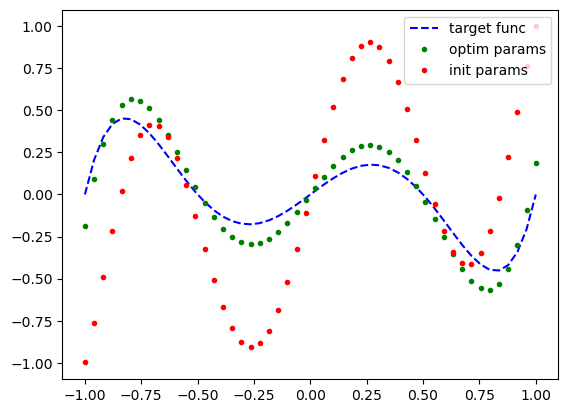

In [7]:
import numpy as np

d = 9  # dim(phi) = d + 1,
num_samples = 50


def custom_poly(x):
    """A custom polynomial of degree <= d and parity d % 2"""
    return torch.tensor(4 * x**5 - 5 * x**3 + x, requires_grad=False, dtype=torch.float)


a_vals = np.linspace(-1, 1, num_samples)
y_true = custom_poly(a_vals)

qsp_model_runner = Model_Runner(QSP_Func_Fit, d, num_samples, a_vals, generate_many_sro, y_true)

qsp_model_runner.execute()
qsp_model_runner.plot_result()

::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
---- iter: 0, loss: 13.5938 -----
---- iter: 1000, loss: 11.8809 -----
---- iter: 2000, loss: 10.229 -----
---- iter: 3000, loss: 8.6693 -----
---- iter: 4000, loss: 7.2557 -----
---- iter: 5000, loss: 6.0084 -----
---- iter: 6000, loss: 4.9197 -----
---- iter: 7000, loss: 3.9801 -----
---- iter: 8000, loss: 3.1857 -----
---- iter: 9000, loss: 2.5312 -----
---- iter: 10000, loss: 2.0045 -----
---- iter: 11000, loss: 1.5873 -----
---- iter: 12000, loss: 1.2594 -----
---- iter: 13000, loss: 1.0021 -----
---- iter: 14000, loss: 0.7997 -----
---- iter: 15000, loss: 0.6397 -----
---- iter: 16000, loss: 0.5127 -----
```

![](../demonstrations/function_fitting_qsp/trained_poly.png){.align-center
width="50.0%"}
:::


We were able to fit that polynomial quite well! Lets try something more
challenging: fitting a non-polynomial function. One thing to keep in
mind is the symmetry and bounds constraints on our polynomials. If our
target function does not satisfy them as well, then we cannot hope to
generate a good polynomial fit, regardless of how long we train for.

A good non-polynomial candidate to fit to, that obeys our constraints,
is the step function. Let's try it!


---- iter: 0, loss: 33.8345 -----
---- iter: 1000, loss: 19.0937 -----
---- iter: 2000, loss: 11.6557 -----
---- iter: 3000, loss: 8.2853 -----
---- iter: 4000, loss: 6.6824 -----
---- iter: 5000, loss: 5.8523 -----
---- iter: 6000, loss: 5.3855 -----
---- iter: 7000, loss: 5.1036 -----
---- iter: 8000, loss: 4.9227 -----
---- iter: 9000, loss: 4.8004 -----
---- iter: 10000, loss: 4.7138 -----
---- iter: 11000, loss: 4.6502 -----
---- iter: 12000, loss: 4.6018 -----
---- iter: 13000, loss: 4.5638 -----
---- iter: 14000, loss: 4.5333 -----
---- iter: 15000, loss: 4.5082 -----
---- iter: 16000, loss: 4.4872 -----
---- iter: 17000, loss: 4.4693 -----
---- iter: 18000, loss: 4.4537 -----
---- iter: 19000, loss: 4.4401 -----
---- iter: 20000, loss: 4.4281 -----
---- iter: 21000, loss: 4.4174 -----
---- iter: 22000, loss: 4.4078 -----
---- iter: 23000, loss: 4.3991 -----
---- iter: 24000, loss: 4.3912 -----
---- iter: 25000, loss: 4.3839 -----


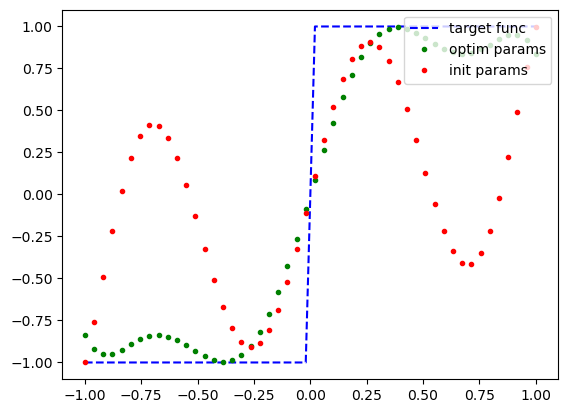

In [8]:
d = 9  # dim(phi) = d + 1,
num_samples = 50


def step_func(x):
    """A step function (odd parity) which maps all values <= 0 to -1
    and all values > 0 to +1.
    """
    res = [-1.0 if x_i <= 0 else 1.0 for x_i in x]
    return torch.tensor(res, requires_grad=False, dtype=torch.float)


a_vals = np.linspace(-1, 1, num_samples)
y_true = step_func(a_vals)

qsp_model_runner = Model_Runner(QSP_Func_Fit, d, num_samples, a_vals, generate_many_sro, y_true)

qsp_model_runner.execute()
qsp_model_runner.plot_result()

::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
---- iter: 0, loss: 33.8345 -----
---- iter: 1000, loss: 19.0937 -----
---- iter: 2000, loss: 11.6557 -----
---- iter: 3000, loss: 8.2853 -----
---- iter: 4000, loss: 6.6824 -----
---- iter: 5000, loss: 5.8523 -----
---- iter: 6000, loss: 5.3855 -----
---- iter: 7000, loss: 5.1036 -----
---- iter: 8000, loss: 4.9227 -----
---- iter: 9000, loss: 4.8004 -----
---- iter: 10000, loss: 4.7138 -----
---- iter: 11000, loss: 4.6502 -----
---- iter: 12000, loss: 4.6018 -----
---- iter: 13000, loss: 4.5638 -----
---- iter: 14000, loss: 4.5333 -----
---- iter: 15000, loss: 4.5082 -----
---- iter: 16000, loss: 4.4872 -----
---- iter: 17000, loss: 4.4693 -----
---- iter: 18000, loss: 4.4537 -----
---- iter: 19000, loss: 4.4401 -----
---- iter: 20000, loss: 4.4281 -----
---- iter: 21000, loss: 4.4174 -----
---- iter: 22000, loss: 4.4078 -----
---- iter: 23000, loss: 4.3991 -----
---- iter: 24000, loss: 4.3912 -----
---- iter: 25000, loss: 4.3839 -----
```

![](../demonstrations/function_fitting_qsp/trained_step.png){.align-center
width="50.0%"}
:::


Conclusion
==========

In this demo, we explored the Quantum Signal Processing theorem, which
is a method to perform polynomial transformations on the entries of the
SRO $\hat{W}(a)$. This polynomial transformation arises from the
repeated application of $\hat{W}(a)$ and the parameterized Z-axis
rotations $e^{i \phi \hat{Z}}$. Note, the SRO is itself a
transformation, in this case a rotation around the X-axis by
$\theta = -2 \cos^{-1}(a)$, which rotates our basis. Thus the underlying
principal of quantum signal processing is that we can generate
polynomial transformations through parameterized rotations along a
principal axis followed by change of basis transformations which
re-orients this axis.

This is the same principal at the heart of QSVT. In this case the
subspace in which we apply our parameterized rotations is defined by the
singular vectors, the change of basis transformation takes us between
these subspaces and this allows us to apply polynomial transformations
on the singular values of our matrix of interest.

We also showed that one could use a simple gradient descent model to
train a parameter vector $\vec{\phi}$ to generate reasonably good
polynomial approximations of arbitrary functions (provided the function
satisfied the same constraints). This isn\'t the only way to compute the
optimal values. It turns out there exist *efficient* algorithms for
explicitly computing the optimal values for $\vec{\phi}$ known as
\"Remez-type exchange algorithms\" for analytic function fitting. If you
want to explore other approaches to function fitting, checkout this
[demo](https://pennylane.ai/qml/demos/quantum_neural_net.html) where we
use a photonic neural network for function fitting.


![](../demonstrations/function_fitting_qsp/trained_step.gif){.align-center
width="50.0%"}


References
==========

\[1\]: *John M. Martyn, Zane M. Rossi, Andrew K. Tan, Isaac L. Chuang.
"A Grand Unification of Quantum Algorithms"* [PRX Quantum 2,
040203](https://arxiv.org/abs/2105.02859)*, 2021.*

About the author
================
